In [ ]:
# ===== base =====
import numpy as np
import pandas as pd

# ===== visualization =====
import matplotlib.pyplot as plt
import seaborn as sns

# ===== system / utils =====
from pathlib import Path
from joblib import dump

# ===== sklearn: model selection & pipelines =====
from sklearn.model_selection import train_test_split, KFold
from sklearn.pipeline import Pipeline

# ===== sklearn: preprocessing & decomposition =====
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# ===== sklearn: models =====
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

# ===== sklearn: metrics =====
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    f1_score,
    precision_score,
    recall_score,
    confusion_matrix,
    classification_report,
)

# ===== gradient boosting models =====
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# Data Preparation and Splitting
1. Data Loading  
Two datasets are loaded:  
era5_data.csv — meteorological features (ERA5)  
k_data.csv — target information and meteorological observations 
The datasets are merged by columns, with the following fields extracted from the target file:  
Timestamp (timestamp)
High-level cloud flag (HLC)  
Total cloud cover  
2. Target Variable Transformation  
Incorrect observation values (HLC = 8, 9) are removed from the sample.  
The target variable is then converted to a binary format:  
1 — clouds present  
0 — clouds absent  
3. Filtering by Observation Consistency  
Only observations meeting the following criteria are retained:  
Clouds are present (HLC = 1) and cloud cover ≥ 4  
Clouds are absent (HLC = 0) and cloud cover = 0  
This step eliminates ambiguous and noisy cases.  
4. Chronological Ordering  
The data is sorted by timestamp to preserve the temporal structure of the observations.  
5. Training, Validation, and Test Splitting  
The split is performed chronologically, without shuffling:  
train — the earliest 70% of the data  
valid — the next 15% of the data preceding the test set  
test — the final 15% of the most recent data  
This approach prevents "data leakage" from the future into the past.  

In [ ]:
target_df = pd.read_csv('k_data.csv')
data_df = pd.read_csv('era5_data.csv')
df = pd.concat([data_df, target_df[['timestamp','HLC','Общее количество облачности']]],axis=1)
# преобразование значения наблюдений метеорологов в классы
df = df[~df['HLC'].isin([8, 9])]
df['HLC'] = df['HLC'].apply(lambda x: 1 if x != 0 else 0)
#фильтр для облаков
df_filtered = df[
   ((df["HLC"] == 1) & (df["Общее количество облачности"] >= 4)) | #для наличия
    ((df["HLC"] == 0) & (df["Общее количество облачности"] <= 0))   #для отсутсвтия 
]
#ручное раздеделение выборки по кускам (времени)
df_filtered = df_filtered.sort_values("timestamp").reset_index(drop=True)

n = int(len(df_filtered) * 0.15) #по 15%

test = df_filtered.iloc[-n:] #15% c конца

valid = df_filtered.iloc[-2*n:-n] #15% перед тестом

train = df_filtered.iloc[:-2*n] #всё что осталось


In [ ]:
drop_cols = ["timestamp", "Общее количество облачности"]

train = train.drop(columns=drop_cols, errors="ignore")
valid = valid.drop(columns=drop_cols, errors="ignore")
test  = test.drop(columns=drop_cols, errors="ignore")
feature_cols = [c for c in train.columns if c != "HLC"]

X_train, y_train = train[feature_cols], train["HLC"]
X_valid, y_valid = valid[feature_cols], valid["HLC"]
X_test,  y_test  = test[feature_cols],  test["HLC"]


# Model Training and Classification Comparison
1. Feature Preparation
For models sensitive to feature scaling, a common preprocessing pipeline is used:
- Feature standardization (StandardScaler)
- Dimensionality reduction using PCA (retaining 95% of variance)
- Output without additional scaling after PCA
This stage is applied to linear, kernel-based, and "simple" models.
2. Model Suite
A diverse set of models is selected for comparison:
- Linear and Kernel-based:
- Logistic Regression, SVM with RBF kernel
Simple Probabilistic:
- Gaussian Naive Bayes, k-Nearest Neighbors
- Gradient Boosting:
- - CatBoost, LightGBM, XGBoost
For datasets with class imbalance, automated or manual class weights are utilized.
3. Unified Interface via Pipeline
Each model is wrapped in a Pipeline, which:
- Guarantees consistent data processing
- Simplifies training and evaluation
- Prevents data leakage
Preprocessing is omitted for boosting models.
4. Model Training
Each model is trained exclusively on the training set (TRAIN).
The validation and test sets are not involved in the training process.
5. Performance Evaluation
Each model is evaluated on:
- The validation set (VALID)
- The test set (TEST)
The following metrics are used:
- ROC AUC (overall class separation ability)
- Confusion matrix (absolute and normalized)
- Precision, Recall, and F1-score calculated separately for each class
- The classification threshold is fixed at 0.5.
6. Visualization
For clearer interpretation, the following are plotted:
- ROC curves
- Confusion matrices (in absolute values and proportions)
7. Results Summary Table
All metrics are compiled into a single table, including:
- Model name
- Dataset (VALID / TEST)
- Class
- ROC AUC
- Precision / Recall / F1-score
- Applied threshold
This enables direct comparison between models and analysis of individual class performance.


==================== TRAINING SVM_RBF on TRAIN only ====================

##### EVAL — METEO VALID — SVM_RBF #####
ROC AUC (overall): 0.8492
Confusion Matrix (counts):
 [[ 921  361]
 [ 220 1106]]
Confusion Matrix (row-normalized):
 [[0.718 0.282]
 [0.166 0.834]]
Classification Report:
               precision    recall  f1-score   support

           0     0.8072    0.7184    0.7602      1282
           1     0.7539    0.8341    0.7920      1326

    accuracy                         0.7772      2608
   macro avg     0.7806    0.7762    0.7761      2608
weighted avg     0.7801    0.7772    0.7764      2608



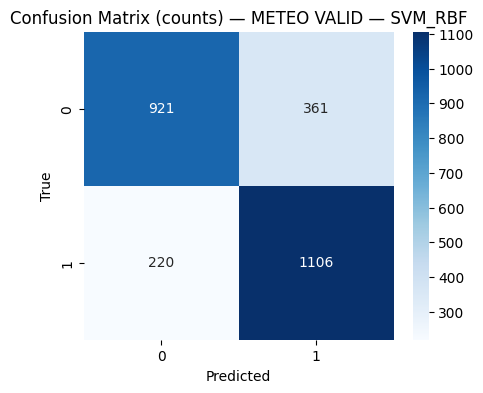

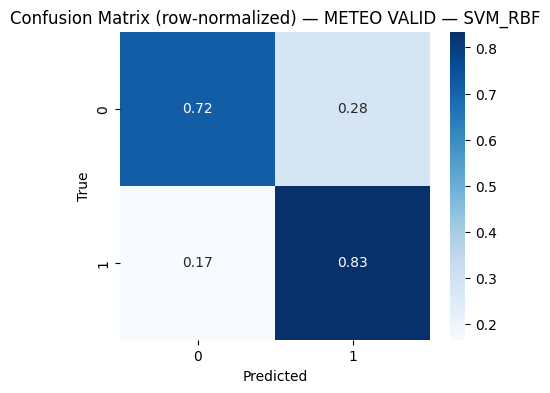


  -> Metrics for class 0: Precision=0.8072, Recall=0.7184, F1=0.7602

  -> Metrics for class 1: Precision=0.7539, Recall=0.8341, F1=0.7920

##### EVAL — МЕТЕО TEST — SVM_RBF #####
ROC AUC (overall): 0.8567
Confusion Matrix (counts):
 [[ 997  356]
 [ 210 1045]]
Confusion Matrix (row-normalized):
 [[0.737 0.263]
 [0.167 0.833]]
Classification Report:
               precision    recall  f1-score   support

           0     0.8260    0.7369    0.7789      1353
           1     0.7459    0.8327    0.7869      1255

    accuracy                         0.7830      2608
   macro avg     0.7860    0.7848    0.7829      2608
weighted avg     0.7875    0.7830    0.7828      2608



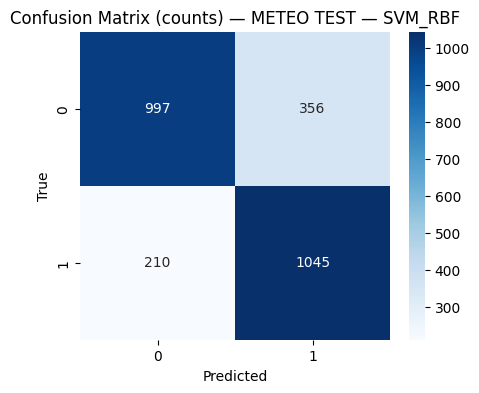

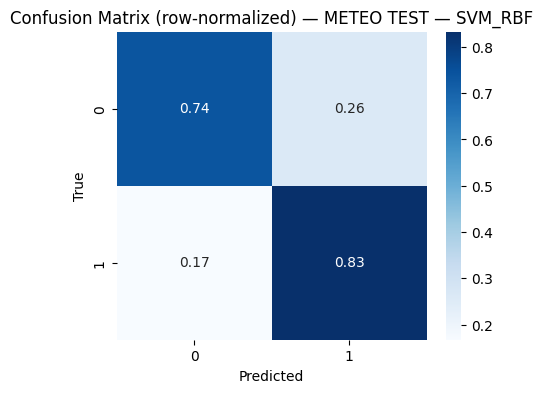


  -> Metrics for class 0: Precision=0.8260, Recall=0.7369, F1=0.7789

  -> Metrics for class 1: Precision=0.7459, Recall=0.8327, F1=0.7869

==================== TRAINING LOGREG on TRAIN only ====================

##### EVAL — METEO VALID — LOGREG #####
ROC AUC (overall): 0.8125
Confusion Matrix (counts):
 [[930 352]
 [352 974]]
Confusion Matrix (row-normalized):
 [[0.725 0.275]
 [0.265 0.735]]
Classification Report:
               precision    recall  f1-score   support

           0     0.7254    0.7254    0.7254      1282
           1     0.7345    0.7345    0.7345      1326

    accuracy                         0.7301      2608
   macro avg     0.7300    0.7300    0.7300      2608
weighted avg     0.7301    0.7301    0.7301      2608



/home/jupyter-hep-user/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/home/jupyter-hep-user/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)


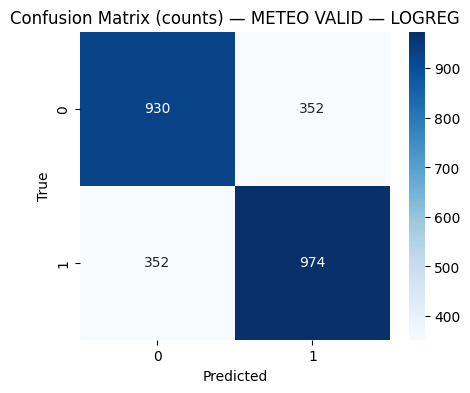

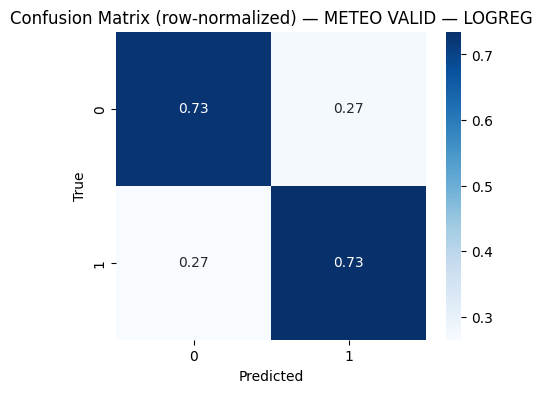


  -> Metrics for class 0: Precision=0.7254, Recall=0.7254, F1=0.7254

  -> Metrics for class 1: Precision=0.7345, Recall=0.7345, F1=0.7345

##### EVAL — МЕТЕО TEST — LOGREG #####
ROC AUC (overall): 0.8331
Confusion Matrix (counts):
 [[1020  333]
 [ 271  984]]
Confusion Matrix (row-normalized):
 [[0.754 0.246]
 [0.216 0.784]]
Classification Report:
               precision    recall  f1-score   support

           0     0.7901    0.7539    0.7716      1353
           1     0.7472    0.7841    0.7652      1255

    accuracy                         0.7684      2608
   macro avg     0.7686    0.7690    0.7684      2608
weighted avg     0.7694    0.7684    0.7685      2608



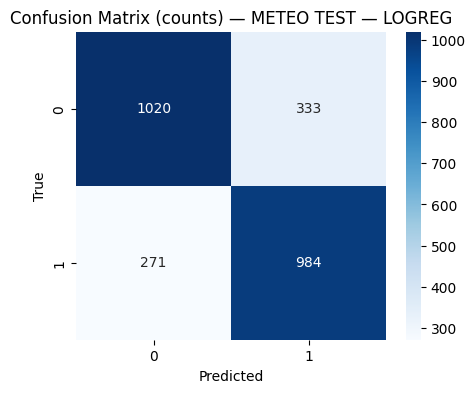

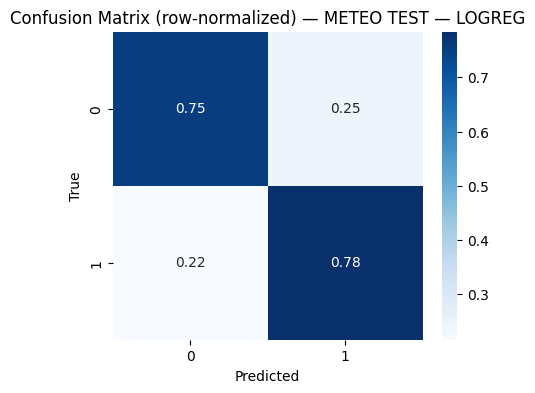


  -> Metrics for class 0: Precision=0.7901, Recall=0.7539, F1=0.7716

  -> Metrics for class 1: Precision=0.7472, Recall=0.7841, F1=0.7652

==================== TRAINING GAUSSIAN_NB on TRAIN only ====================

##### EVAL — METEO VALID — GAUSSIAN_NB #####
ROC AUC (overall): 0.7815
Confusion Matrix (counts):
 [[ 772  510]
 [ 263 1063]]
Confusion Matrix (row-normalized):
 [[0.602 0.398]
 [0.198 0.802]]
Classification Report:
               precision    recall  f1-score   support

           0     0.7459    0.6022    0.6664      1282
           1     0.6758    0.8017    0.7334      1326

    accuracy                         0.7036      2608
   macro avg     0.7108    0.7019    0.6999      2608
weighted avg     0.7102    0.7036    0.7004      2608



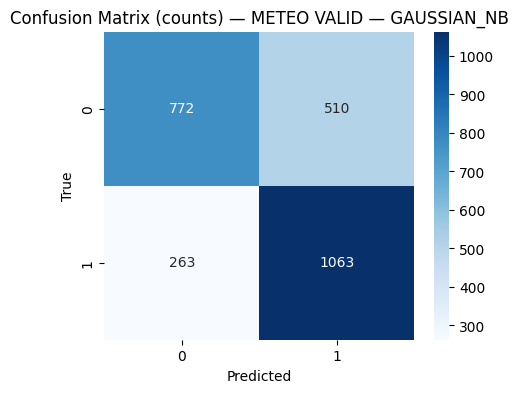

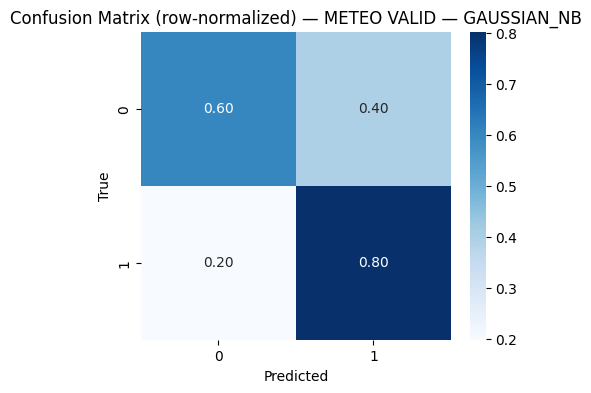


  -> Metrics for class 0: Precision=0.7459, Recall=0.6022, F1=0.6664

  -> Metrics for class 1: Precision=0.6758, Recall=0.8017, F1=0.7334

##### EVAL — МЕТЕО TEST — GAUSSIAN_NB #####
ROC AUC (overall): 0.8229
Confusion Matrix (counts):
 [[ 912  441]
 [ 217 1038]]
Confusion Matrix (row-normalized):
 [[0.674 0.326]
 [0.173 0.827]]
Classification Report:
               precision    recall  f1-score   support

           0     0.8078    0.6741    0.7349      1353
           1     0.7018    0.8271    0.7593      1255

    accuracy                         0.7477      2608
   macro avg     0.7548    0.7506    0.7471      2608
weighted avg     0.7568    0.7477    0.7466      2608



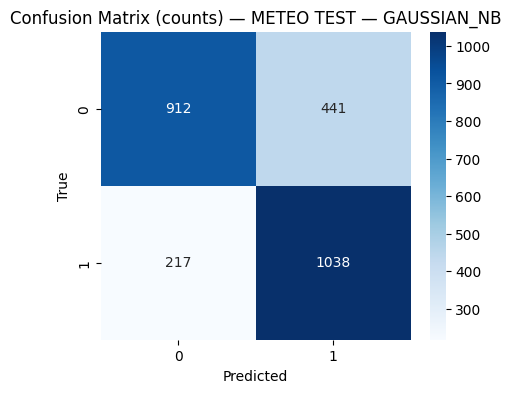

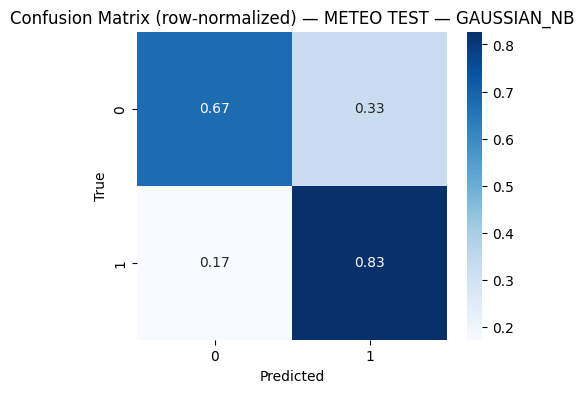


  -> Metrics for class 0: Precision=0.8078, Recall=0.6741, F1=0.7349

  -> Metrics for class 1: Precision=0.7018, Recall=0.8271, F1=0.7593

==================== TRAINING KNN on TRAIN only ====================

##### EVAL — METEO VALID — KNN #####
ROC AUC (overall): 0.8152
Confusion Matrix (counts):
 [[ 904  378]
 [ 287 1039]]
Confusion Matrix (row-normalized):
 [[0.705 0.295]
 [0.216 0.784]]
Classification Report:
               precision    recall  f1-score   support

           0     0.7590    0.7051    0.7311      1282
           1     0.7332    0.7836    0.7576      1326

    accuracy                         0.7450      2608
   macro avg     0.7461    0.7444    0.7443      2608
weighted avg     0.7459    0.7450    0.7446      2608



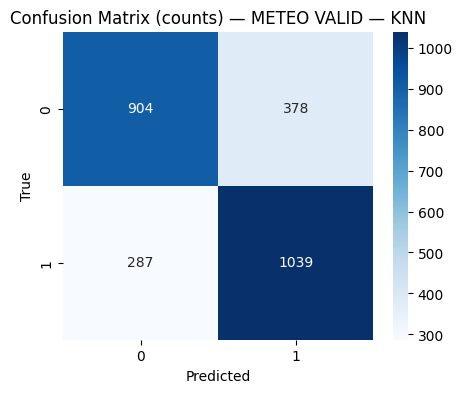

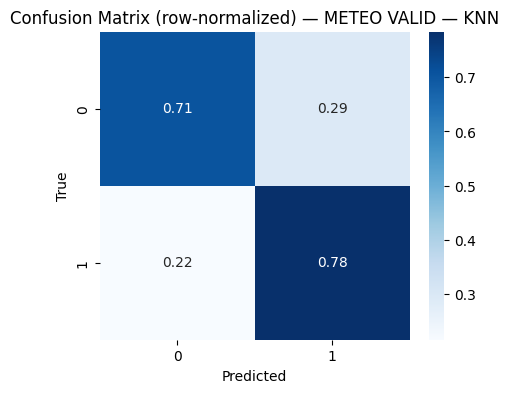


  -> Metrics for class 0: Precision=0.7590, Recall=0.7051, F1=0.7311

  -> Metrics for class 1: Precision=0.7332, Recall=0.7836, F1=0.7576

##### EVAL — МЕТЕО TEST — KNN #####
ROC AUC (overall): 0.8322
Confusion Matrix (counts):
 [[1001  352]
 [ 257  998]]
Confusion Matrix (row-normalized):
 [[0.74  0.26 ]
 [0.205 0.795]]
Classification Report:
               precision    recall  f1-score   support

           0     0.7957    0.7398    0.7668      1353
           1     0.7393    0.7952    0.7662      1255

    accuracy                         0.7665      2608
   macro avg     0.7675    0.7675    0.7665      2608
weighted avg     0.7685    0.7665    0.7665      2608



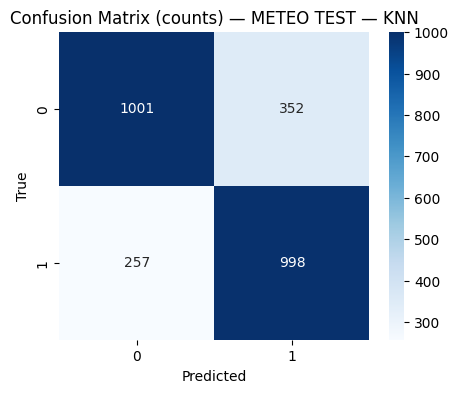

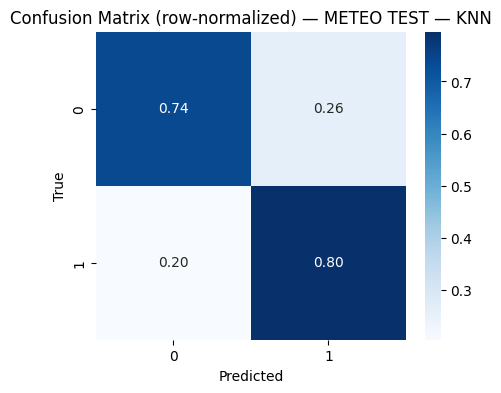


  -> Metrics for class 0: Precision=0.7957, Recall=0.7398, F1=0.7668

  -> Metrics for class 1: Precision=0.7393, Recall=0.7952, F1=0.7662

==================== TRAINING CATBOOST on TRAIN only ====================

##### EVAL — METEO VALID — CATBOOST #####
ROC AUC (overall): 0.8677
Confusion Matrix (counts):
 [[ 959  323]
 [ 232 1094]]
Confusion Matrix (row-normalized):
 [[0.748 0.252]
 [0.175 0.825]]
Classification Report:
               precision    recall  f1-score   support

           0     0.8052    0.7480    0.7756      1282
           1     0.7721    0.8250    0.7977      1326

    accuracy                         0.7872      2608
   macro avg     0.7886    0.7865    0.7866      2608
weighted avg     0.7884    0.7872    0.7868      2608



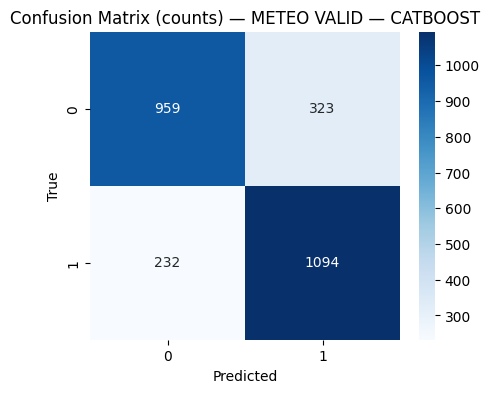

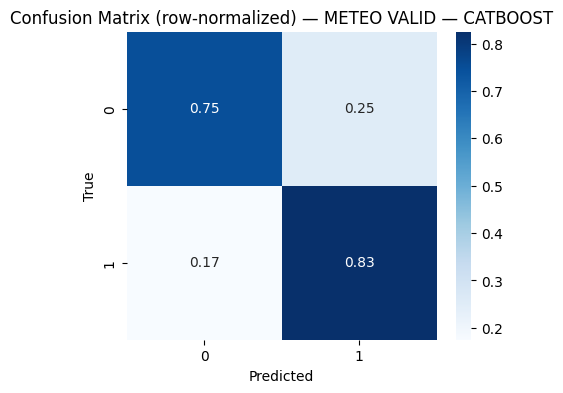


  -> Metrics for class 0: Precision=0.8052, Recall=0.7480, F1=0.7756

  -> Metrics for class 1: Precision=0.7721, Recall=0.8250, F1=0.7977

##### EVAL — МЕТЕО TEST — CATBOOST #####
ROC AUC (overall): 0.8758
Confusion Matrix (counts):
 [[1033  320]
 [ 204 1051]]
Confusion Matrix (row-normalized):
 [[0.763 0.237]
 [0.163 0.837]]
Classification Report:
               precision    recall  f1-score   support

           0     0.8351    0.7635    0.7977      1353
           1     0.7666    0.8375    0.8005      1255

    accuracy                         0.7991      2608
   macro avg     0.8008    0.8005    0.7991      2608
weighted avg     0.8021    0.7991    0.7990      2608



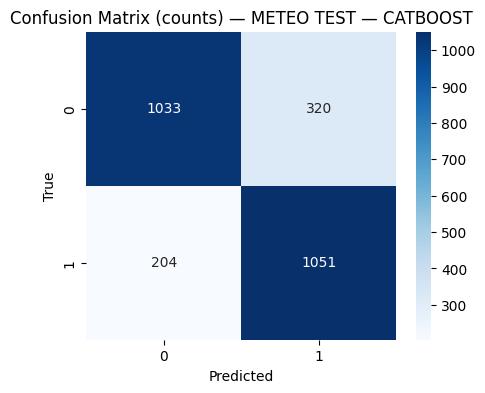

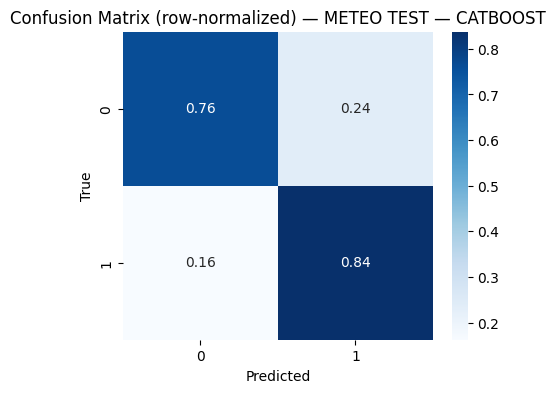


  -> Metrics for class 0: Precision=0.8351, Recall=0.7635, F1=0.7977

  -> Metrics for class 1: Precision=0.7666, Recall=0.8375, F1=0.8005

==================== TRAINING LIGHTGBM on TRAIN only ====================
[LightGBM] [Info] Number of positive: 6614, number of negative: 5563
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.113144 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43686
[LightGBM] [Info] Number of data points in the train set: 12177, number of used features: 173
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000

##### EVAL — METEO VALID — LIGHTGBM #####
ROC AUC (overall): 0.8686
Confusion Matrix (counts):
 [[ 955  327]
 [ 227 1099]]
Confusion Matrix (row-normalized):
 [[0.745 0.255]
 [0.171 0.829]]
Classification Report:
               precision    recall  f1-score   support

           0     0.80

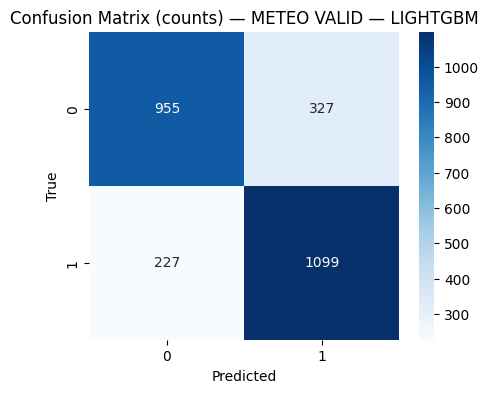

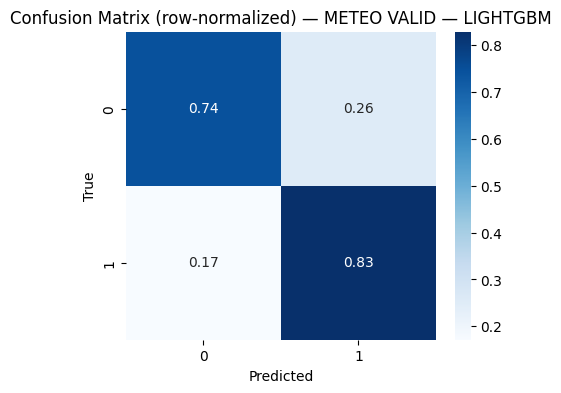


  -> Metrics for class 0: Precision=0.8080, Recall=0.7449, F1=0.7752

  -> Metrics for class 1: Precision=0.7707, Recall=0.8288, F1=0.7987

##### EVAL — МЕТЕО TEST — LIGHTGBM #####
ROC AUC (overall): 0.8750
Confusion Matrix (counts):
 [[1021  332]
 [ 196 1059]]
Confusion Matrix (row-normalized):
 [[0.755 0.245]
 [0.156 0.844]]
Classification Report:
               precision    recall  f1-score   support

           0     0.8389    0.7546    0.7946      1353
           1     0.7613    0.8438    0.8005      1255

    accuracy                         0.7975      2608
   macro avg     0.8001    0.7992    0.7975      2608
weighted avg     0.8016    0.7975    0.7974      2608



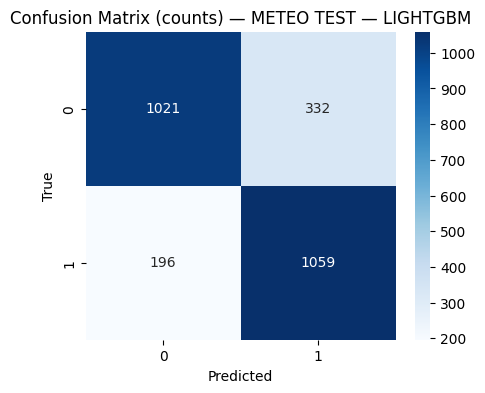

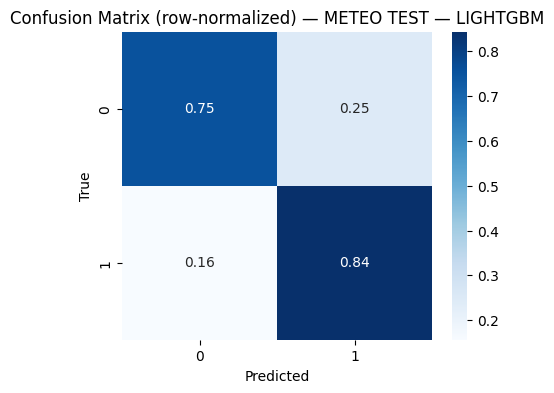


  -> Metrics for class 0: Precision=0.8389, Recall=0.7546, F1=0.7946

  -> Metrics for class 1: Precision=0.7613, Recall=0.8438, F1=0.8005

==================== TRAINING XGBOOST on TRAIN only ====================

##### EVAL — METEO VALID — XGBOOST #####
ROC AUC (overall): 0.8697
Confusion Matrix (counts):
 [[ 950  332]
 [ 218 1108]]
Confusion Matrix (row-normalized):
 [[0.741 0.259]
 [0.164 0.836]]
Classification Report:
               precision    recall  f1-score   support

           0     0.8134    0.7410    0.7755      1282
           1     0.7694    0.8356    0.8012      1326

    accuracy                         0.7891      2608
   macro avg     0.7914    0.7883    0.7883      2608
weighted avg     0.7910    0.7891    0.7885      2608



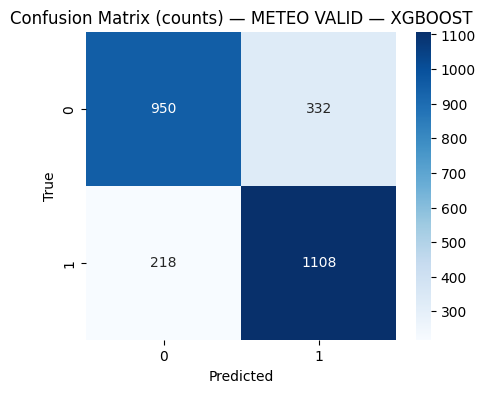

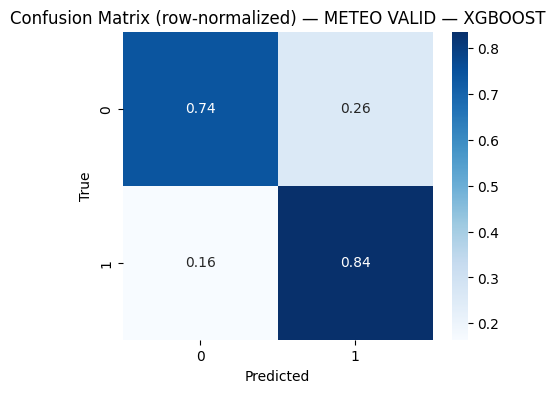


  -> Metrics for class 0: Precision=0.8134, Recall=0.7410, F1=0.7755

  -> Metrics for class 1: Precision=0.7694, Recall=0.8356, F1=0.8012

##### EVAL — МЕТЕО TEST — XGBOOST #####
ROC AUC (overall): 0.8755
Confusion Matrix (counts):
 [[1005  348]
 [ 190 1065]]
Confusion Matrix (row-normalized):
 [[0.743 0.257]
 [0.151 0.849]]
Classification Report:
               precision    recall  f1-score   support

           0     0.8410    0.7428    0.7889      1353
           1     0.7537    0.8486    0.7984      1255

    accuracy                         0.7937      2608
   macro avg     0.7974    0.7957    0.7936      2608
weighted avg     0.7990    0.7937    0.7934      2608



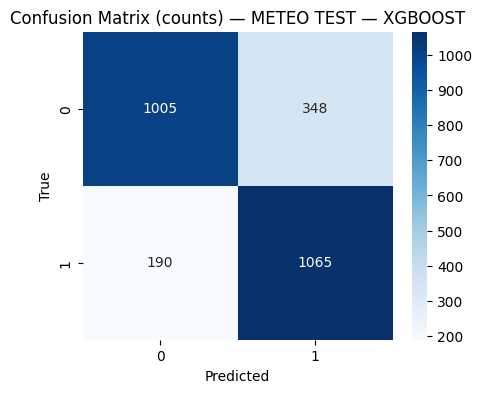

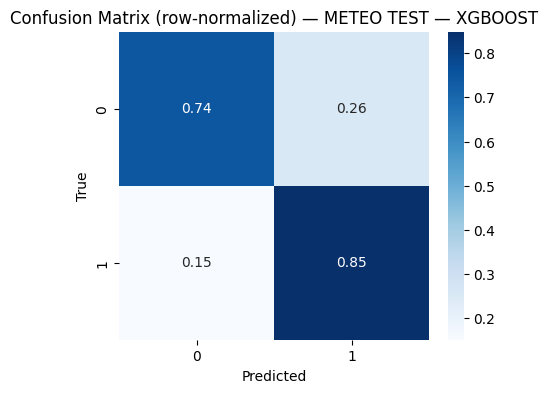


  -> Metrics for class 0: Precision=0.8410, Recall=0.7428, F1=0.7889

  -> Metrics for class 1: Precision=0.7537, Recall=0.8486, F1=0.7984

===== METRICS SUMMARY (train on TRAIN, eval on VALID/TEST, per class) =====
          model      dataset  class_label   ROC_AUC  Precision    Recall  \
0      CATBOOST  METEO VALID            0  0.867739   0.805206  0.748050   
1      CATBOOST  METEO VALID            1  0.867739   0.772054  0.825038   
2      CATBOOST   МЕТЕО TEST            0  0.875844   0.835085  0.763489   
3      CATBOOST   МЕТЕО TEST            1  0.875844   0.766594  0.837450   
4   GAUSSIAN_NB  METEO VALID            0  0.781535   0.745894  0.602184   
5   GAUSSIAN_NB  METEO VALID            1  0.781535   0.675779  0.801659   
6   GAUSSIAN_NB   МЕТЕО TEST            0  0.822889   0.807795  0.674058   
7   GAUSSIAN_NB   МЕТЕО TEST            1  0.822889   0.701826  0.827092   
8           KNN  METEO VALID            0  0.815209   0.759026  0.705148   
9           KNN  METEO 

In [ ]:
prep = Pipeline(steps=[
    ("scaler_pre", StandardScaler()),
    ("pca", PCA(n_components=0.95, random_state=42)),
    ("scaler_post", "passthrough"),
])

svm_rbf = SVC(
    kernel="rbf",
    C=1.0,
    gamma="scale",
    probability=True,
    random_state=42,
    cache_size=2000,
    class_weight="balanced",
)

logreg = LogisticRegression(
    C=1.0,
    penalty="l2",
    solver="saga",
    max_iter=2000,
    n_jobs=-1,
    random_state=42,
    class_weight="balanced",
)

gnb = GaussianNB()
knn = KNeighborsClassifier(
    n_neighbors=15,
    weights="distance",
    metric="minkowski",
    n_jobs=-1
)

cat_model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    loss_function="Logloss",
    eval_metric="AUC",
    auto_class_weights="Balanced",
    random_state=42,
    verbose=False,
)

lgbm_model = LGBMClassifier(
    n_estimators=1000,
    learning_rate=0.05,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary",
    class_weight="balanced",
    n_jobs=-1,
    random_state=42,
)

xgb_model = XGBClassifier(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary:logistic",
    eval_metric="auc",
    n_jobs=-1,
    tree_method="hist",
    random_state=42,
)

pipelines = {
    # линейные / ядровые
    "SVM_RBF":      Pipeline([("prep", prep), ("model", svm_rbf)]),
    "LOGREG":       Pipeline([("prep", prep), ("model", logreg)]),
    # простые вероятностные
    "GAUSSIAN_NB":  Pipeline([("prep", prep), ("model", gnb)]),
    "KNN":          Pipeline([("prep", prep), ("model", knn)]),
    # бустинги
    "CATBOOST":     Pipeline([("model", cat_model)]),
    "LIGHTGBM":     Pipeline([("model", lgbm_model)]),
    "XGBOOST":      Pipeline([("model", xgb_model)]),
}

def _plot_roc(y_true, proba, title):
    auc = roc_auc_score(y_true, proba)
    fpr, tpr, _ = roc_curve(y_true, proba)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f"AUC={auc:.3f}")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("FPR"); plt.ylabel("TPR")
    plt.title(title); plt.legend()
    plt.show()
    return auc

def _plot_cm(cm, title, fmt='d'):
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt=fmt, cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted'); plt.ylabel('True')
    plt.show()

def _evaluate_one(tag, name, pipe, X, y, thr=0.5, plot=True):
    """Оценка на одном датасете + метрики для ОБОИХ классов."""
    proba = pipe.predict_proba(X)[:, 1]
    y_hat = (proba >= thr).astype(int)

    # общий ROC AUC
    auc = roc_auc_score(y, proba)

    # confusion matrices
    cm = confusion_matrix(y, y_hat)
    with np.errstate(invalid='ignore', divide='ignore'):
        row_sums = cm.sum(axis=1, keepdims=True)
        cm_norm = cm / np.where(row_sums == 0, 1, row_sums)

    print(f"\n##### EVAL — {tag} — {name} #####")
    print(f"ROC AUC (overall): {auc:.4f}")
    print("Confusion Matrix (counts):\n", cm)
    print("Confusion Matrix (row-normalized):\n", np.round(cm_norm, 3))
    print("Classification Report:\n", classification_report(y, y_hat, digits=4))

    if plot:
        _plot_cm(cm,     f'Confusion Matrix (counts) — {tag} — {name}', fmt='d')
        _plot_cm(cm_norm,f'Confusion Matrix (row-normalized) — {tag} — {name}', fmt='.2f')

    # метрики по классам
    results = []
    classes = np.unique(y)
    for cls in classes:
        prec = precision_score(y, y_hat, pos_label=cls, zero_division=0)
        rec  = recall_score(y,  y_hat, pos_label=cls, zero_division=0)
        f1   = f1_score(y,      y_hat, pos_label=cls, zero_division=0)

        print(f"\n  -> Metrics for class {cls}: Precision={prec:.4f}, Recall={rec:.4f}, F1={f1:.4f}")

        results.append({
            "model": name,
            "dataset": tag,
            "class_label": int(cls),
            "ROC_AUC": float(auc),      # общий AUC один и тот же для обоих классов
            "Precision": float(prec),
            "Recall": float(rec),
            "F1": float(f1),
            "threshold": float(thr),
        })

    return results

eval_datasets = [
    ("METEO VALID",      X_valid,          y_valid),
    ("МЕТЕО TEST",       X_test,           y_test),
]

all_summaries = []

for name, base_pipe in pipelines.items():
    print(f"\n==================== TRAINING {name} on TRAIN only ====================")
    final_pipe = Pipeline(base_pipe.steps)
    final_pipe.fit(X_train, y_train)

    for tag, X_eval, y_eval in eval_datasets:
        rows = _evaluate_one(tag=tag, name=name, pipe=final_pipe,
                             X=X_eval, y=y_eval, thr=0.5, plot=True)
        all_summaries.extend(rows)

metrics_df = pd.DataFrame(all_summaries).sort_values(["model", "dataset", "class_label"]).reset_index(drop=True)
print("\n===== METRICS SUMMARY (train on TRAIN, eval on VALID/TEST, per class) =====")
print(metrics_df)
